While we dive into many algorithms over the course of this book, I want to drive home that machine learning models _need_ data to learn. We can have the fanciest neural network on the best GPU cluster in the world, but without data, it's all pointless. To drive this point home let's build a linear regression on the simplest of equations.

We'll start with a line. Nothing special, just the equation `f(x) = x + 1`.

<Axes: >

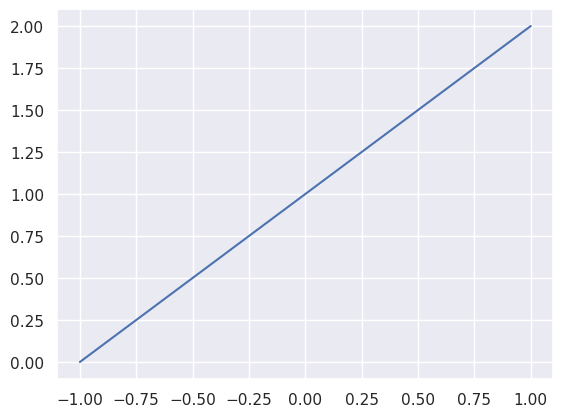

In [1]:
# | eval: false
import seaborn as sns

sns.set_theme(style="darkgrid")


def f(x):
    """Function that applies `x + 1` to `x`."""
    return x + 1

def get_y(xs):
    """Return `y` for every `x` in the list `xs`."""
    return list(map(f, xs))


x = [-1, 1]
y = get_y(x)
sns.lineplot(x=x, y=y)

This line is the ground truth. It is real. But let's imagine we don't have the line. We just have a couple random points on the line.

<Axes: >

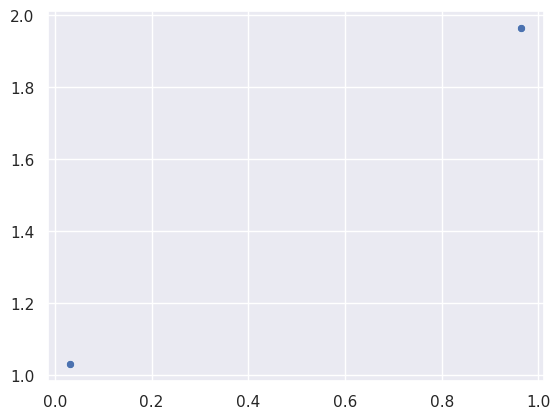

In [2]:
# | eval: false
import random
import pandas as pd

random.seed(100392)


def random_x(n):
    """Return `n` random values from -1 to 1."""
    return [random.uniform(-1, 1) for _ in range(n)]


xs = random_x(2)
ys = get_y(xs)
sns.scatterplot(x=xs, y=ys)

Visually, we could draw a line from dot to dot and we'd get the same line in the previous plot. But we're not interested in figuring out the line ourselves. We're here to have machine learning do it for us. This is already integrated into `seaborn` so there's not much code for us to write. The [`regplot`](https://seaborn.pydata.org/generated/seaborn.regplot.html) function will plot our data points and use machine learning to fit a line to those data points.

<Axes: >

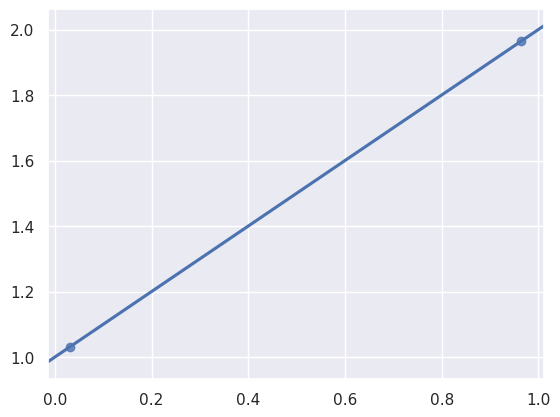

In [3]:
# | eval: false
sns.regplot(x=xs, y=ys, truncate=False, ci=False)

Will you look at that! The line was perfectly predicted based on the data points.

But real world data isn't this simple or this _clean_. There's usually some amount of noise in the data that can affect the quality of predictions. Noise is randomness introduced to the data. It can come from many places like imprecise measurements, mislabelling, or unaccounted variables to name a few.

Now let's imagine we don't have points on the line, but points close to the line. How will this change the predicted line?

<Axes: >

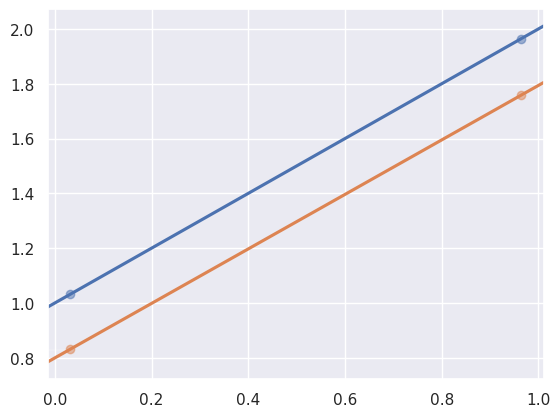

In [4]:
# | eval: false
# Add noise to the data points to simulate noisy data.
def noisy_process(xs, noise):
    """Return `f(x)` with noise."""
    return [
        y + random.uniform(-noise, noise)
        for x, y in zip(xs, get_y(xs))
    ]


ys_noisy = noisy_process(xs, 0.25)

ax = sns.regplot(
    x=xs,
    y=ys,
    truncate=False,
    ci=False,
    scatter_kws={"alpha": 0.5},
)
sns.regplot(
    x=xs,
    y=ys_noisy,
    truncate=False,
    ci=False,
    ax=ax,
    scatter_kws={"alpha": 0.5},
)

Hmm, that doesn't look so bad. The predicted line in orange is pretty close to the real line in blue and has the same slope. But what if we just got lucky and the random noise happened to be low? Maybe we should run it a few more times to be sure.

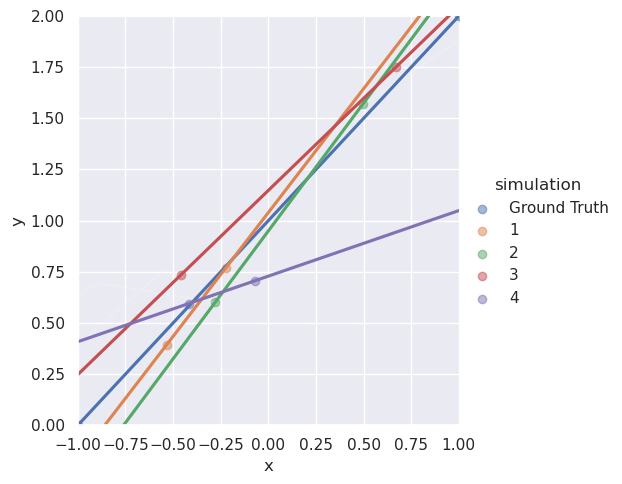

In [5]:
# | eval: false
import pandas as pd


def simulate_n(n, n_points, noise):
    """
    Return a `pd.DataFrame` with `n` separate simulations
    of `n_points`.
    """
    data = []
    real_x = [-1, 1]
    real_y = get_y(real_x)
    for x, y in zip(real_x, real_y):
        data.append(
            {
                "x": x,
                "y": y,
                "simulation": "Ground Truth",
                "noise": noise,
            }
        )
    for i in range(n):
        xs = random_x(n_points)
        ys = noisy_process(xs, noise)
        for x, y in zip(xs, ys):
            data.append(
                {
                    "x": x,
                    "y": y,
                    "simulation": i + 1,
                    "noise": noise,
                }
            )
    return pd.DataFrame(data)


df = simulate_n(4, 2, 0.25)
# `lmplot` is a fancier version of `regplot` that can handle
# multiple lines.
sns.lmplot(
    df,
    x="x",
    y="y",
    ci=False,
    hue="simulation",
    truncate=False,
    scatter_kws={"alpha": 0.5},
    facet_kws={"xlim": (-1, 1), "ylim": (0, 2)},
)

Most of these look pretty close to the blue line, the ground truth, but what's going on with simulation 4? The noise confused the machine learning model. It only has two points to work with and given two points it can figure out a line that perfectly lies on those two points. These two points imperfectly represent the real line and so the machine learned the line of this imperfect representation. And it gets worse with more noise.

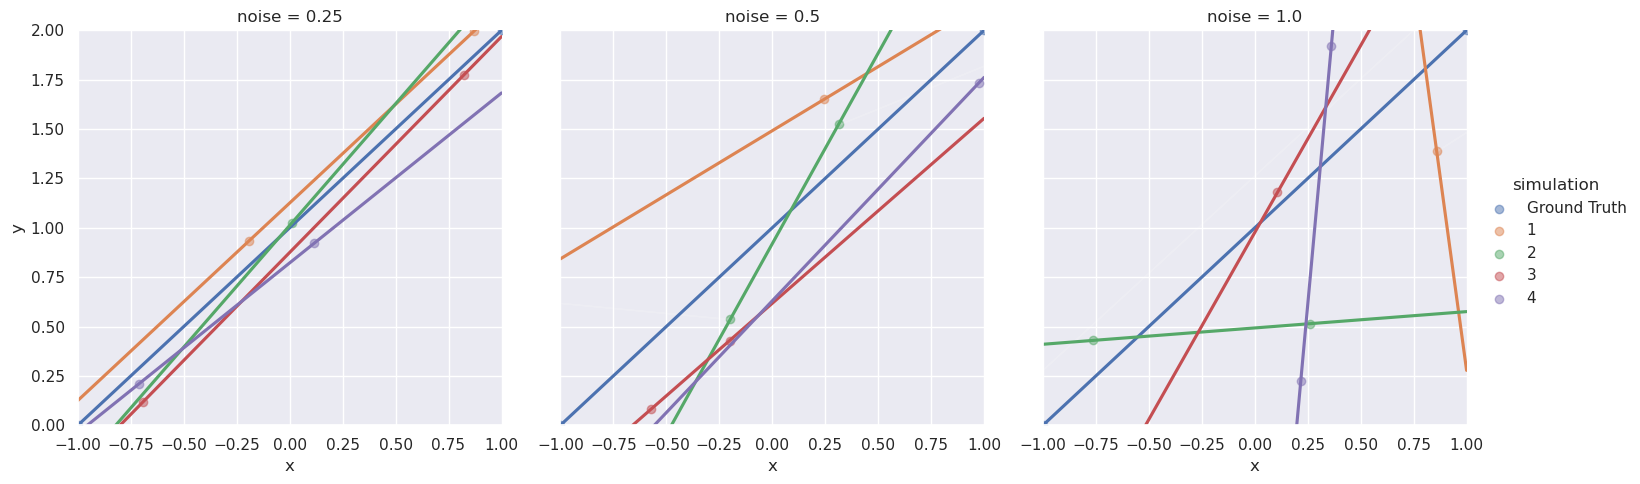

In [6]:
# | eval: false
df = pd.concat(
    [simulate_n(4, 2, noise) for noise in [0.25, 0.5, 1]]
)
sns.lmplot(
    df,
    x="x",
    y="y",
    ci=False,
    hue="simulation",
    truncate=False,
    col="noise",
    scatter_kws={"alpha": 0.5},
    facet_kws={"xlim": (-1, 1), "ylim": (0, 2)},
)

Yup, that's a mess. At `noise = 0.5` the lines start to drift from the real line and at `noise = 1.0` most of them aren't even close. But all is not lost, there is a way to learn from noisy data. Use more of it! Let's try a hundred points per simulation.

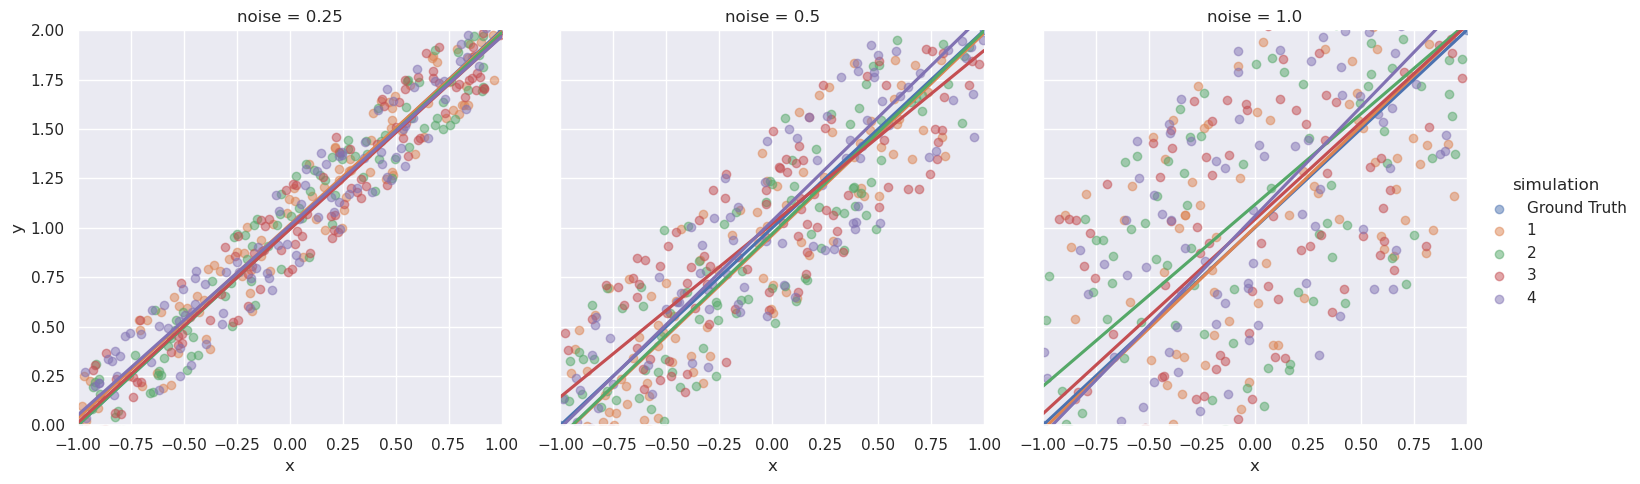

In [7]:
# | eval: false
df = pd.concat(
    [simulate_n(4, 100, noise) for noise in [0.25, 0.5, 1]]
)
sns.lmplot(
    df,
    x="x",
    y="y",
    ci=False,
    hue="simulation",
    truncate=False,
    col="noise",
    scatter_kws={"alpha": 0.5},
    facet_kws={"xlim": (-1, 1), "ylim": (0, 2)},
)

That's night and day compared to two data points. Even when `noise = 1.0` the machine learning model does a good job of finding the line. This is because there's more information to learn from and the machine learning model can separate the noise and zero in on the truth.

The lesson here is data quality is important, but so is data _quantity_. Sometimes the answer is a better machine learning model, but that's not always true, you might just need more data. On the other hand, if you can't get enough data, you may need better _quality_ data.